# Polarity prediction on movie reviews, comparison of parameters and learning methods

## Importing libraries
(scikit-learn for learning, nltk for text processing and pandas for data reprensentations)

## Learning methods
To classify a vector of numbers, we used :

- Logistic regression
- MultinomialNB
- kNN
- Random Forest

## Text representations
We tried different representations of data to see how it influences the learning :
- Bag-of-words
- n-grams
- Term frequency (bag-of-words normalized)
- Term frequency times inverse document frequency 

## Importing libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from scikitplot.metrics import plot_confusion_matrix

## Importing the datasets
(We used the small dataset)

In [9]:
# Get all files path
posFiles = glob('review_polarity/txt_sentoken/pos/*')
negFiles = glob('review_polarity/txt_sentoken/neg/*')
# Read text files
posReviews = np.array([open(f).read() for f in posFiles])
negReviews = np.array([open(f).read() for f in negFiles])
# Use pandas to label, mix the data and print a sample
polarity_files_df = pd.DataFrame({'pos':posReviews,'neg':negReviews})
polarity_files_df = pd.melt(polarity_files_df, value_vars=['pos','neg'],value_name="text",var_name="label")
polarity_files_df["label_num"] = polarity_files_df.label.map({"neg":0, "pos":1})
polarity_files_df.sample(5)

,label,text,label_num
1557,neg,"when i was nine , i started buying the coolest...",0
451,pos,""" the endurance : shackleton's legendary anta...",1
1922,neg,i have never seen a man so in love with himsel...,0
1095,neg,they should have stuck to the promise emblazon...,0
441,pos,"in some regards , making a movie is like tryin...",1


## Split and shuffle the data
Used when comparing confusion matrices

In [10]:
# Split and shuffle the data (15% for train and 85% for tests)

X_train, X_test, y_train, y_test = train_test_split(polarity_files_df.text, polarity_files_df.label_num, test_size=0.15, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1700,)
(300,)
(1700,)
(300,)


## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

### Influence of parameters

In [19]:
# Test a range of hyperparameters
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', max_df =0.7, min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('lr', LogisticRegression())
                    ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf' : (True,False),
              'lr__C' : (0.5, 1.0, 2.0)
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, return_train_score=True)

gs_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'lr__C': (0.5, 1.0, 2.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
# Getting the best scores
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

print(gs_clf.best_score_)

df = pd.DataFrame({'rank':gs_clf.cv_results_['rank_test_score'], 
                  'ngram_range':gs_clf.cv_results_['param_vect__ngram_range'],
                  'tfidf':gs_clf.cv_results_['param_tfidf__use_idf'],
                  'lr__C':gs_clf.cv_results_['param_lr__C'],
                  'mean_test_score':gs_clf.cv_results_['mean_test_score'], 
                  'mean_train_score':gs_clf.cv_results_['mean_train_score']}).set_index('rank')

df.sort_values('rank',ascending=True).head(10)

lr__C: 2.0
tfidf__use_idf: True
vect__ngram_range: (1, 1)
0.8270588235294117


,ngram_range,tfidf,lr__C,mean_test_score,mean_train_score
rank,,,,,
1,"(1, 1)",True,2,0.827059,0.995000
2,"(1, 2)",True,1,0.825882,0.991764
2,"(1, 2)",True,2,0.825882,0.998235
4,"(1, 1)",True,1,0.825294,0.986470
5,"(1, 1)",True,0.5,0.818235,0.972057
5,"(1, 2)",True,0.5,0.818235,0.983234
7,"(1, 2)",False,2,0.815294,0.984117
8,"(1, 1)",False,2,0.814706,0.977647
9,"(1, 2)",False,1,0.808824,0.961177


### Confusion matrix on bag-of-words

We remove English stop words:
this includes 1-grams and 2-grams (we did not take into account 3-grams because of the length of the vector).
We ignore terms that appear in more than 70% of the documents, which is intuitively meaningful: with 60% of word frequency in english, we still find words such as "uh" in our texts.
We only keep terms that appear in at least 2 documents not to generalize on a very specific example.

We did keep in mind that removing "stop-words" can lead in information loss



/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         pos       0.87      0.85      0.86       151
         neg       0.86      0.87      0.86       149

   micro avg       0.86      0.86      0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

0.8633333333333333


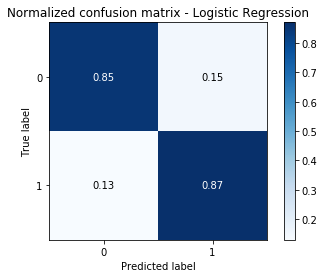

In [34]:
# text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)),
                     ('nb', LogisticRegression()),
                    ])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, target_names=["pos","neg"]))
print(metrics.accuracy_score(y_test, y_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix - Logistic Regression')

## MultinomialNB

In [27]:
from sklearn.naive_bayes import MultinomialNB

### Influence of parameters

In [ ]:
# Test a range of hyperparameters
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', max_df =0.7, min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('m_nb', MultinomialNB())
                    ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf' : (True,False),
              'nb__alpha': (0.,1.,2.)
              # TODO : change m_nb parameters
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, return_train_score=True)

gs_clf.fit(X_train, y_train)

In [31]:
# Getting the 10 best scores
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

print(gs_clf.best_score_)

df = pd.DataFrame({'rank':gs_clf.cv_results_['rank_test_score'], 
                  'ngram_range':gs_clf.cv_results_['param_vect__ngram_range'],
                  'tfidf':gs_clf.cv_results_['param_tfidf__use_idf'],
                  'nb__alpha':gs_clf.cv_results_['param_nb__alpha'],
                  'mean_test_score':gs_clf.cv_results_['mean_test_score'], 
                  'mean_train_score':gs_clf.cv_results_['mean_train_score']}).set_index('rank')

df.sort_values('rank',ascending=True).head(10)

nb__alpha: 2.0
tfidf__use_idf: True
vect__ngram_range: (1, 1)
0.8182352941176471


,ngram_range,tfidf,nb__alpha,mean_test_score,mean_train_score
rank,,,,,
1,"(1, 1)",True,2,0.818235,0.968235
2,"(1, 1)",False,1,0.813529,0.955587
3,"(1, 1)",True,1,0.812941,0.973529
4,"(1, 2)",True,2,0.811765,0.980588
5,"(1, 2)",False,1,0.810588,0.965587
6,"(1, 2)",True,1,0.810000,0.986470
7,"(1, 1)",False,2,0.808824,0.943823
8,"(1, 2)",False,2,0.807647,0.954411
9,"(1, 2)",False,0,0.748824,1.000000


### Confusion matrix on bag-of-words

              precision    recall  f1-score   support

         pos       0.81      0.81      0.81       151
         neg       0.81      0.81      0.81       149

   micro avg       0.81      0.81      0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300

0.8066666666666666


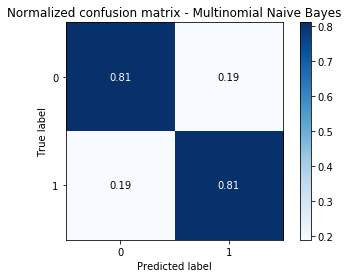

In [38]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)),
                     ('nb', MultinomialNB()),
                    ])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, target_names=["pos","neg"]))
print(metrics.accuracy_score(y_test, y_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix - Multinomial Naive Bayes')

## K-Nearest Neighbors

In [39]:
from sklearn.neighbors import KNeighborsClassifier

### Influence of parameters

In [40]:
# Test a range of hyperparameters
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', max_df =0.7, min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('knn', KNeighborsClassifier()),
                    ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf' : (True,False),
              'knn__n_neighbors': (10, 25, 50),
              'knn__p' : (1,2),
              'knn__weights': ('uniform', 'distance')
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, return_train_score=True)

gs_clf.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'knn__n_neighbors': (10, 25, 50), 'knn__p': (1, 2), 'knn__weights': ('uniform', 'distance')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [42]:
# Getting the 10 best scores
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

print(gs_clf.best_score_)

df = pd.DataFrame({'rank':gs_clf.cv_results_['rank_test_score'], 
                  'ngram_range':gs_clf.cv_results_['param_vect__ngram_range'],
                  'tfidf':gs_clf.cv_results_['param_tfidf__use_idf'],
                  'knn__n_neighbors': gs_clf.cv_results_['param_knn__n_neighbors'],
                  'knn__p': gs_clf.cv_results_['param_knn__p'], 
                  'knn__weights': gs_clf.cv_results_['param_knn__weights'], 
                  'mean_test_score':gs_clf.cv_results_['mean_test_score'], 
                  'mean_train_score':gs_clf.cv_results_['mean_train_score']}).set_index('rank')

df.sort_values('rank',ascending=True).head(10)

knn__n_neighbors: 50
knn__p: 2
knn__weights: 'distance'
tfidf__use_idf: True
vect__ngram_range: (1, 1)
0.7552941176470588


,ngram_range,tfidf,knn__n_neighbors,knn__p,knn__weights,mean_test_score,mean_train_score
rank,,,,,,,
1,"(1, 1)",True,50,2,distance,0.755294,1.000000
2,"(1, 2)",True,50,2,distance,0.748235,1.000000
3,"(1, 2)",True,50,2,uniform,0.741176,0.769418
4,"(1, 1)",True,50,2,uniform,0.736471,0.777358
5,"(1, 2)",False,50,2,distance,0.734706,1.000000
6,"(1, 1)",False,50,2,distance,0.727647,1.000000
7,"(1, 2)",False,25,2,distance,0.726471,1.000000
8,"(1, 2)",False,25,2,uniform,0.725294,0.757354
9,"(1, 2)",False,50,2,uniform,0.722353,0.749417


### Confusion matrix on bag-of-words

              precision    recall  f1-score   support

         pos       0.53      0.98      0.69       151
         neg       0.86      0.13      0.22       149

   micro avg       0.56      0.56      0.56       300
   macro avg       0.70      0.55      0.46       300
weighted avg       0.70      0.56      0.46       300

0.5566666666666666


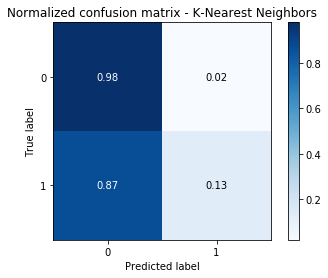

In [43]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)),
                     ('nb', KNeighborsClassifier()),
                    ])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, target_names=["pos","neg"]))
print(metrics.accuracy_score(y_test, y_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix - K-Nearest Neighbors')

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

### Influence of parameters

In [45]:
# Test a range of hyperparameters
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', max_df =0.7, min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('rdc', RandomForestClassifier())
                    ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf' : (True,False),
              'rdc__n_estimators': (10, 25, 50)
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, return_train_score=True)

gs_clf.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'rdc__n_estimators': (10, 25, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
# Getting the 10 best scores
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

print(gs_clf.best_score_)

df = pd.DataFrame({'rank':gs_clf.cv_results_['rank_test_score'], 
                  'ngram_range':gs_clf.cv_results_['param_vect__ngram_range'],
                  'tfidf':gs_clf.cv_results_['param_tfidf__use_idf'],
                  'rdc__n_estimators': gs_clf.cv_results_['param_rdc__n_estimators'],
                  'mean_test_score':gs_clf.cv_results_['mean_test_score'], 
                  'mean_train_score':gs_clf.cv_results_['mean_train_score']
                  }).set_index('rank')

df.sort_values('rank',ascending=True).head(10)

rdc__n_estimators: 50
tfidf__use_idf: False
vect__ngram_range: (1, 1)
0.7711764705882352


,ngram_range,tfidf,rdc__n_estimators,mean_test_score,mean_train_score
rank,,,,,
1,"(1, 1)",False,50,0.771176,1.000000
2,"(1, 1)",True,50,0.765294,1.000000
2,"(1, 2)",True,50,0.765294,1.000000
4,"(1, 2)",False,50,0.755882,1.000000
5,"(1, 1)",False,25,0.752941,0.999412
6,"(1, 2)",True,25,0.741176,1.000000
7,"(1, 1)",True,25,0.728824,0.999412
7,"(1, 2)",False,25,0.728824,0.999706
9,"(1, 2)",False,10,0.682353,0.989118


### Confusion matrix on bag-of-words

/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

         pos       0.70      0.79      0.74       151
         neg       0.75      0.65      0.70       149

   micro avg       0.72      0.72      0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300

0.72


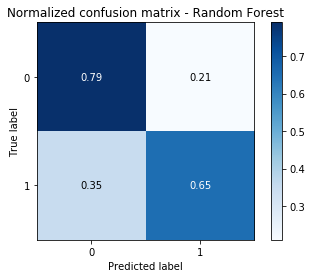

In [48]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)),
                     ('rdc', RandomForestClassifier()),
                    ])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, target_names=["pos","neg"]))
print(metrics.accuracy_score(y_test, y_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix - Random Forest')